# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

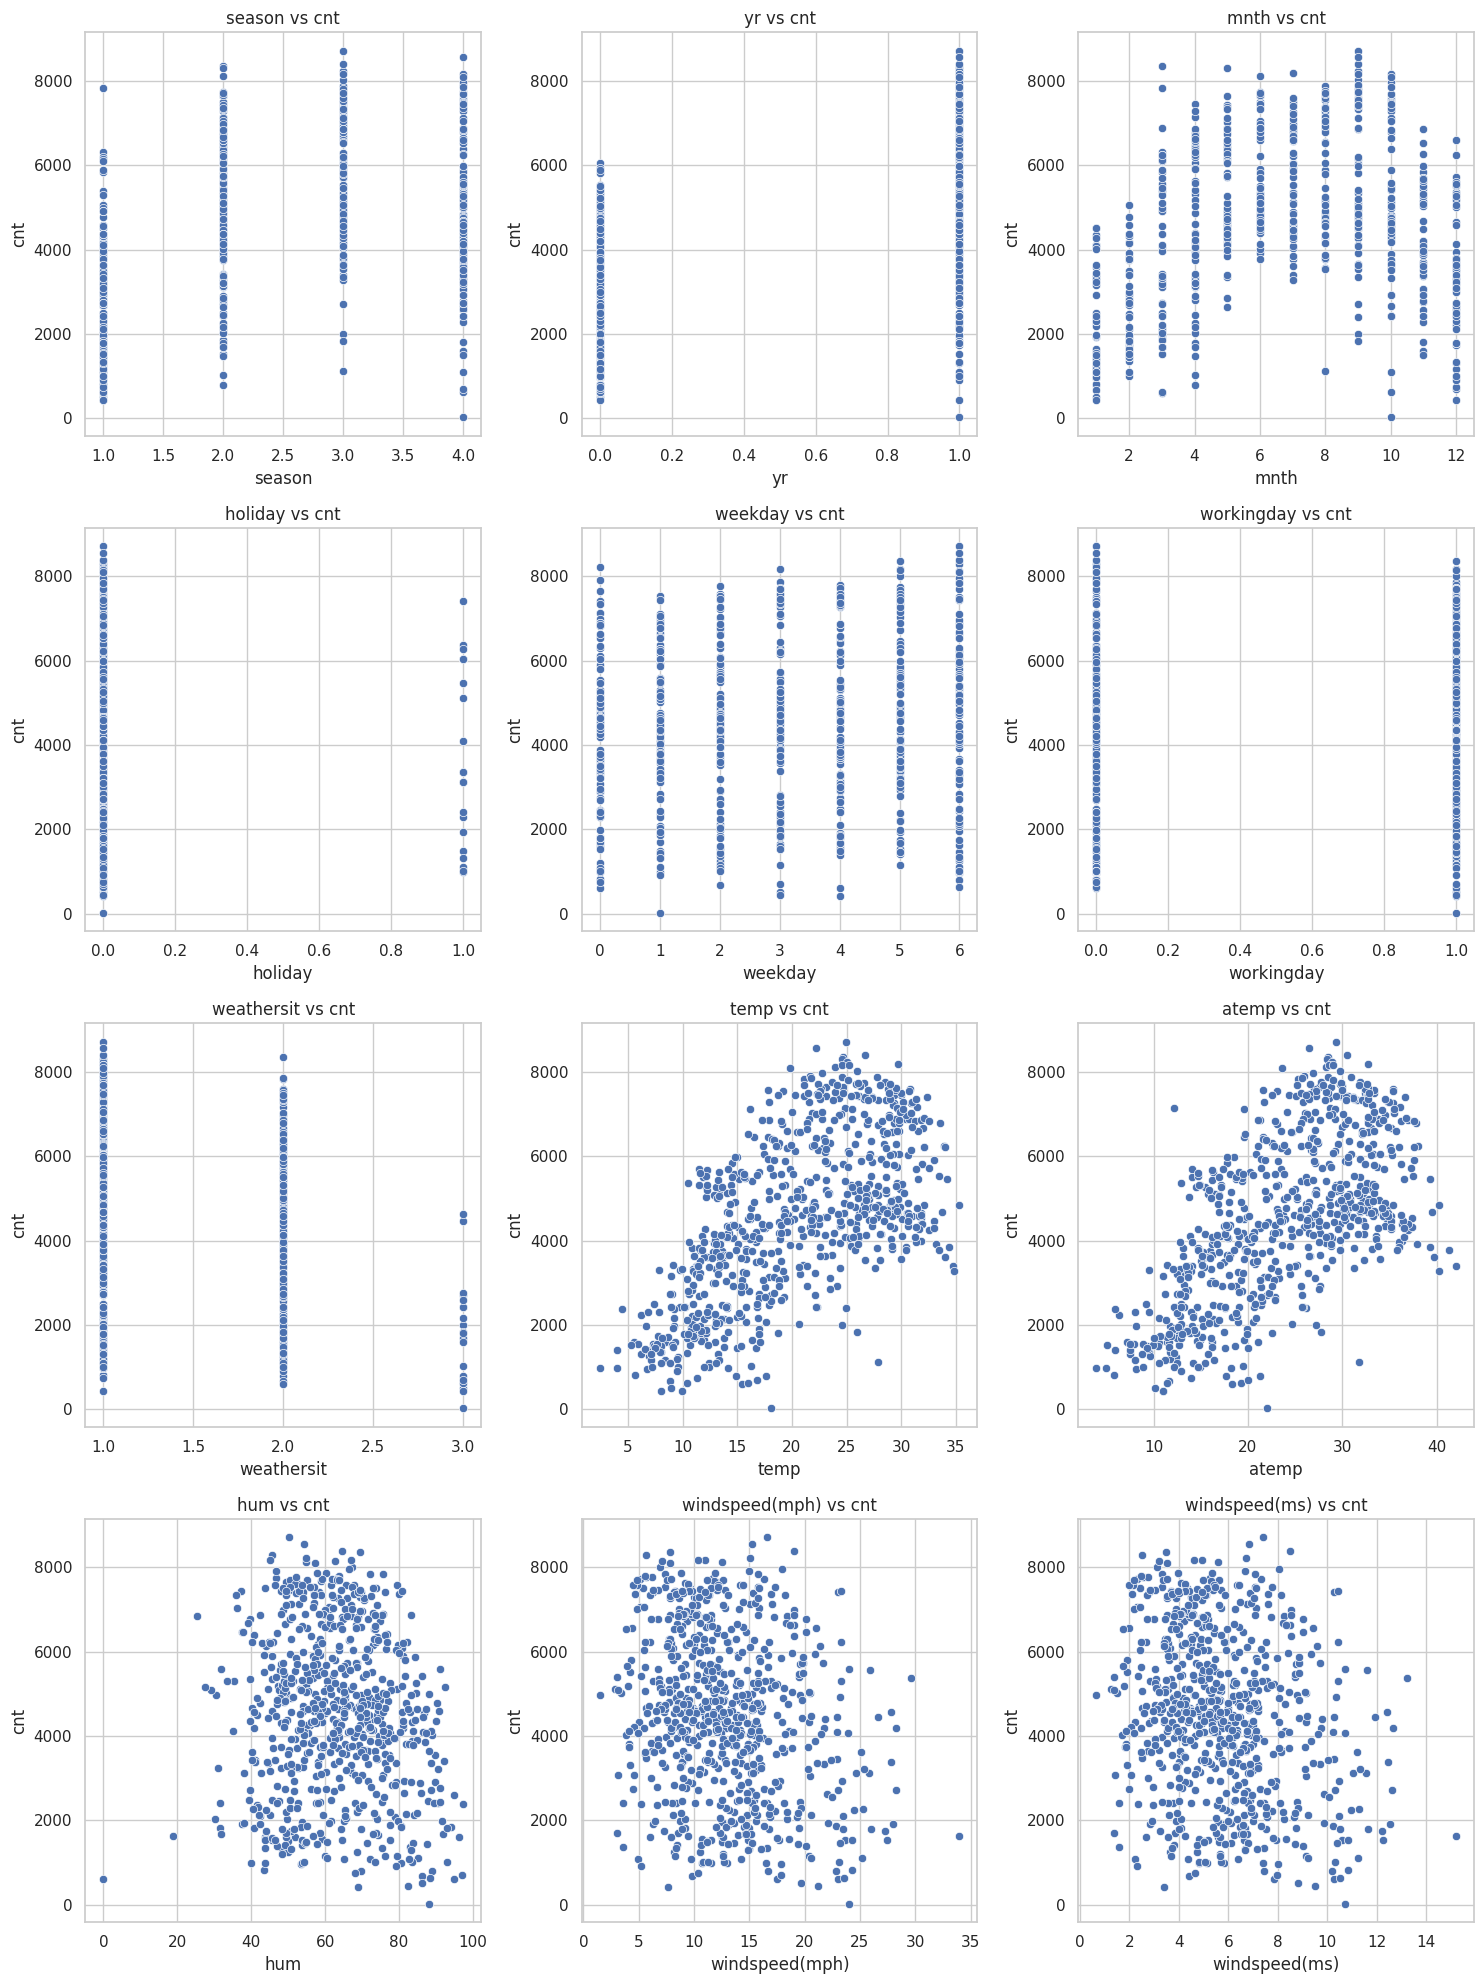

In [5]:
sns.set(style="whitegrid")

attributes = df.columns.to_list()[:-1]
plt.figure(figsize=(15, 20))

for i, attribute in enumerate(attributes, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(x=attribute, y='cnt', data=df)
    plt.title(f'{attribute} vs cnt')

plt.tight_layout()
plt.show()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
Квадратичная функция(парабола)

1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

temp: температура в Цельсиях
atemp: температура по ощущениям в Цельсиях

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

Корреляции между признаками и целевой переменной:
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


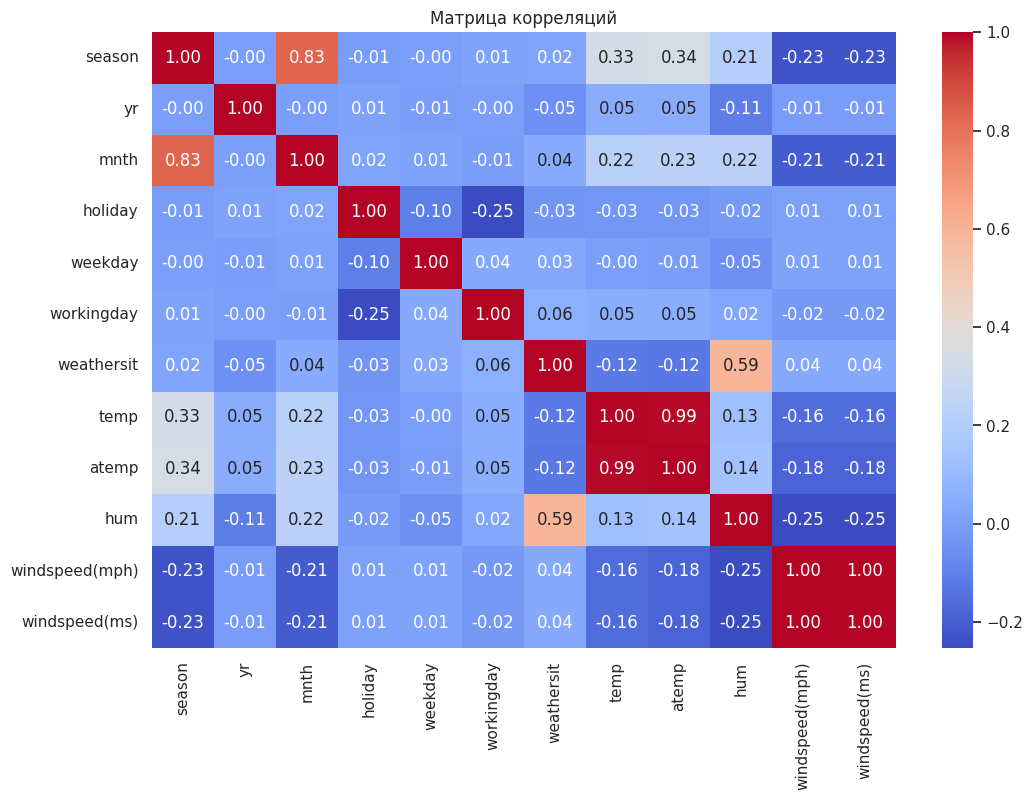

In [7]:
correlations = df.iloc[:, :-1].corrwith(df['cnt'])
print("Корреляции между признаками и целевой переменной:")
print(correlations)

plt.figure(figsize=(12, 8))
sns.heatmap(df.iloc[:, :-1].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций')
plt.show()

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

Попарные корреляции между признаками:
                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


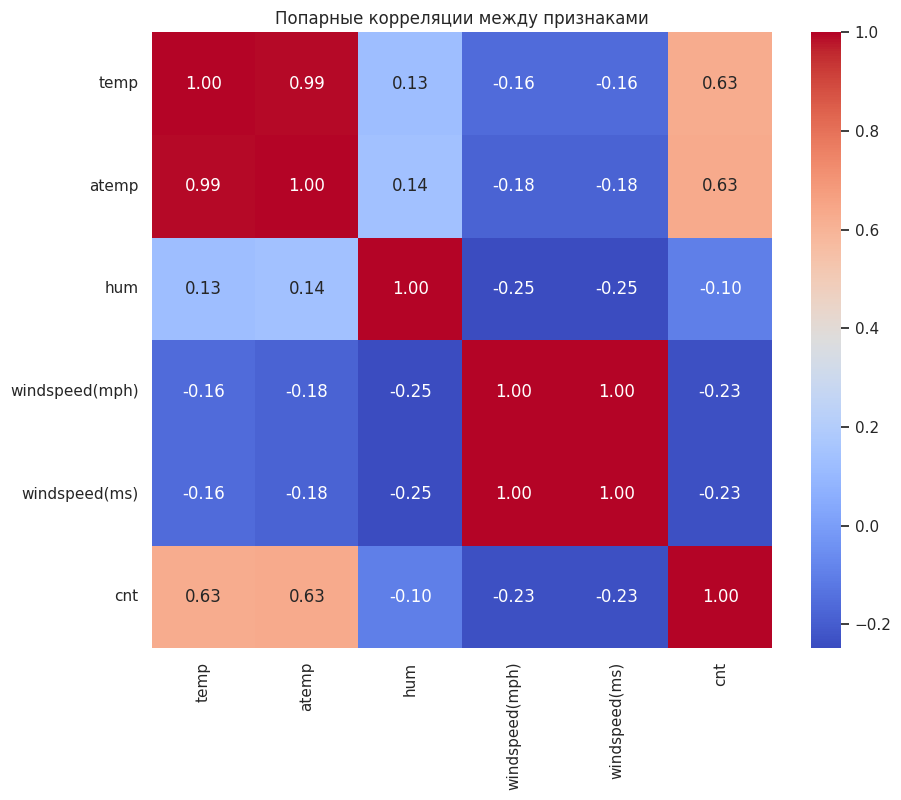

In [11]:
selected_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

correlations_selected = df[selected_features].corr()
print("Попарные корреляции между признаками:")
print(correlations_selected)

plt.figure(figsize=(10, 8))
sns.heatmap(correlations_selected, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Попарные корреляции между признаками')
plt.show()


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [12]:
means = df.mean()
print("Средние значения:")
print(means)

Средние значения:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [13]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression

In [15]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]
model = LinearRegression()
model.fit(X, y)

weights = model.coef_
print("\nВеса признаков после обучения модели:")
print(weights)


Веса признаков после обучения модели:
[ 5.70863796e+02  1.02196538e+03 -1.41301745e+02 -8.67593446e+01
  1.37225064e+02  5.63918818e+01 -3.30226462e+02  3.67483733e+02
  5.85549386e+02 -1.45614306e+02  1.24571384e+13 -1.24571384e+13]


Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [16]:
X = df[df.columns[:-1]]
y = df["cnt"]

model = LinearRegression()
model.fit(X, y)

feature_weights = list(zip(df.columns, model.coef_))
for feature, weight in feature_weights:
    print(f"{feature}: {weight}")

season: 514.2756689772416
yr: 2043.9333206099773
mnth: -40.96317631503962
holiday: -519.3860417173415
weekday: 68.49569506058863
workingday: 121.29281595858514
weathersit: -606.4542679476724
temp: 48.994172947818015
atemp: 71.9163310082323
hum: -10.230641893838651
windspeed(mph): 2400995993962.544
windspeed(ms): -5371028038579.01


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

In [18]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler

X = df[df.columns[:-1]]
y = df["cnt"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_scaled, y)

ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_scaled, y)


lasso_weights = list(zip(df.columns, lasso_model.coef_))
ridge_weights = list(zip(df.columns, ridge_model.coef_))

print("Веса признаков после обучения модели с L1 (Lasso) регуляризатором:")
for feature, weight in lasso_weights:
    print(f"{feature}: {weight}")

print("\nВеса признаков после обучения модели с  L2 (Ridge) регуляризатором:")
for feature, weight in ridge_weights:
    print(f"{feature}: {weight}")

Веса признаков после обучения модели с L1 (Lasso) регуляризатором:
season: 565.3216570612014
yr: 1020.256101516135
mnth: -133.89500587503764
holiday: -86.66727917692951
weekday: 138.2198342161667
workingday: 55.870356750161406
weathersit: -332.69555472955363
temp: 377.3683235504581
atemp: 575.6727820441095
hum: -144.8712467181348
windspeed(mph): -198.10557751372008
windspeed(ms): -2.8272933678995603e-08

Веса признаков после обучения модели с  L2 (Ridge) регуляризатором:
season: 565.5927961447978
yr: 1020.2102053573403
mnth: -134.20179351818587
holiday: -86.69921614667165
weekday: 138.3231201090738
workingday: 55.950171824160954
weathersit: -332.6627869363582
temp: 372.9090809742716
atemp: 580.1125852260761
hum: -145.01904705128845
windspeed(mph): -99.06044565923634
windspeed(ms): -99.06044638669424


### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [19]:
X = df[df.columns[:-1]]
y = df["cnt"]

lasso_model = Lasso()

lasso_model.fit(X, y)

lasso_weights = list(zip(df.columns, lasso_model.coef_))

print("Веса признаков после обучения модели с L1 (Lasso) регуляризатором:")
for feature, weight in lasso_weights:
    print(f"{feature}: {weight}")

Веса признаков после обучения модели с L1 (Lasso) регуляризатором:
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [20]:
X = df[df.columns[:-1]]
y = df["cnt"]

ridge_model = Ridge()
ridge_model.fit(X, y)

ridge_weights = list(zip(df.columns, ridge_model.coef_))

print("\nВеса признаков после обучения модели с L2 (Ridge) регуляризатором:")
for feature, weight in ridge_weights:
    print(f"{feature}: {weight}")


Веса признаков после обучения модели с L2 (Ridge) регуляризатором:
season: 507.8018818505763
yr: 2029.0890541970502
mnth: -38.470897279124635
holiday: -493.2780154838191
weekday: 69.11396965165964
workingday: 121.5244250292943
weathersit: -605.205555373153
temp: 49.31676759598743
atemp: 71.7859872733456
hum: -10.383394500484615
windspeed(mph): -31.93550169428455
windspeed(ms): -14.276040263842843


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [21]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X, y)
    coefs_lasso.append(lasso_model.coef_)

    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X, y)
    coefs_ridge.append(ridge_model.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)


print("Веса признаков для L1-регуляризации (Lasso) при разных значениях alpha:")
print(coefs_lasso)

print("\nВеса признаков для L2-регуляризации (Ridge) при разных значениях alpha:")
print(coefs_ridge)


Веса признаков для L1-регуляризации (Lasso) при разных значениях alpha:
[[ 506.55127865 2036.2316677   -38.07827029 -484.65194619   68.93837479
   118.44759759 -604.56671189   51.36326059   69.91273749  -10.3527052
   -38.34106761   -0.        ]
 [ 363.38298622 1818.17950113   -0.           -0.           55.24105548
     0.         -291.33521188   44.34993053   83.88557181  -18.81320743
   -43.35682101   -0.        ]
 [ 294.88974192 1604.19359695    9.74208093   -0.           37.4493754
     0.           -0.           37.46764176   95.93389064  -26.48659474
   -48.19495616   -0.        ]
 [ 188.43126588 1400.65605911   33.03502814   -0.           24.19007609
     0.           -0.           33.15169023  102.54337981  -26.88669007
   -47.85305889   -0.        ]
 [  81.95521364 1197.14314149   56.33124542   -0.           10.96345655
     0.           -0.           27.55035178  110.33369233  -27.29091458
   -47.46769509   -0.        ]
 [   0.          994.19323854   73.37527257   -0.      

Проанализируйте динамику весов при увеличении параметра регуляризации:

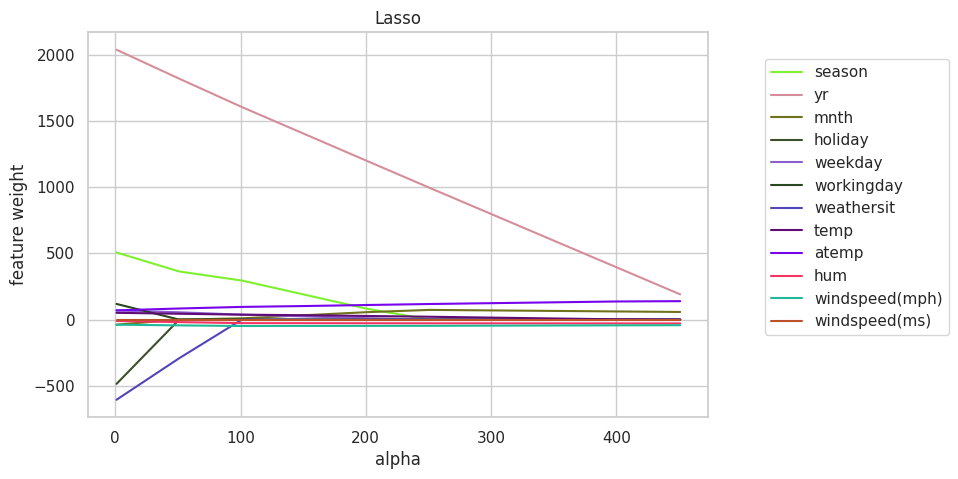

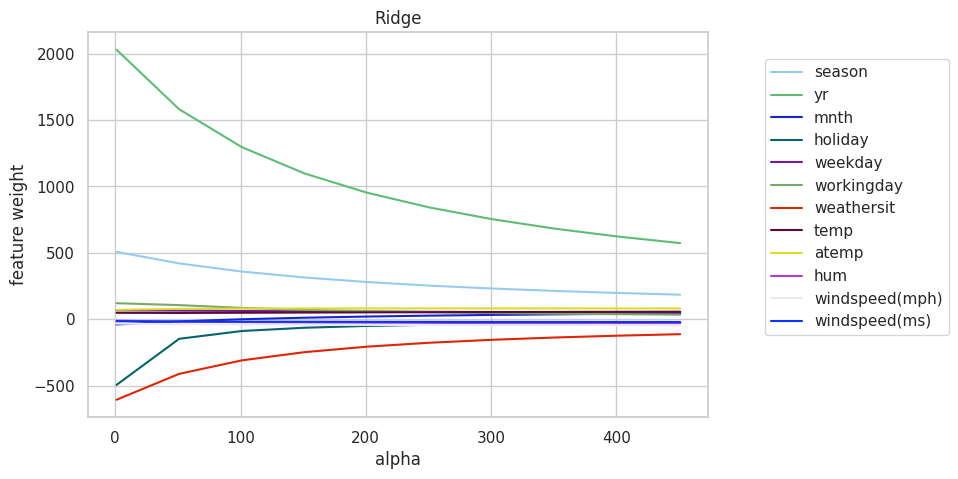

In [23]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
Lasso (L1-регуляризатор) агрессивнее уменьшает веса при одном и том же alpha по сравнению с Ridge (L2-регуляризатором). L1-регуляризатор, в отличие от L2-регуляризатора, способен обнулить веса некоторых признаков, делая модель более разреженной.



1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
Если установить очень большое значение alpha для Lasso, то большинство весов признаков будут обнулены. Это происходит из-за особенности L1-регуляризатора, который включает в себя штраф за абсолютные значения весов. При увеличении alpha увеличивается величина штрафа, и оптимальное решение становится таким, чтобы многие веса обнулились.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
Да, Lasso обнуляет один из признаков windspeed при любом значении alpha > 0. Это происходит из-за того, что windspeed(mph) и windspeed(ms) сильно коррелированы, и L1-регуляризатор предпочтет оставить только один из них. В то время как Ridge не исключает признаки полностью, а только уменьшает их веса.

1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
L1-регуляризатор (Lasso) более подходит для отбора неинформативных признаков, так как он способен обнулять веса признаков, делая модель более интерпретируемой и экономичной по количеству используемых признаков. Ridge склонен уменьшать веса всех признаков, но не обнуляет их полностью.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

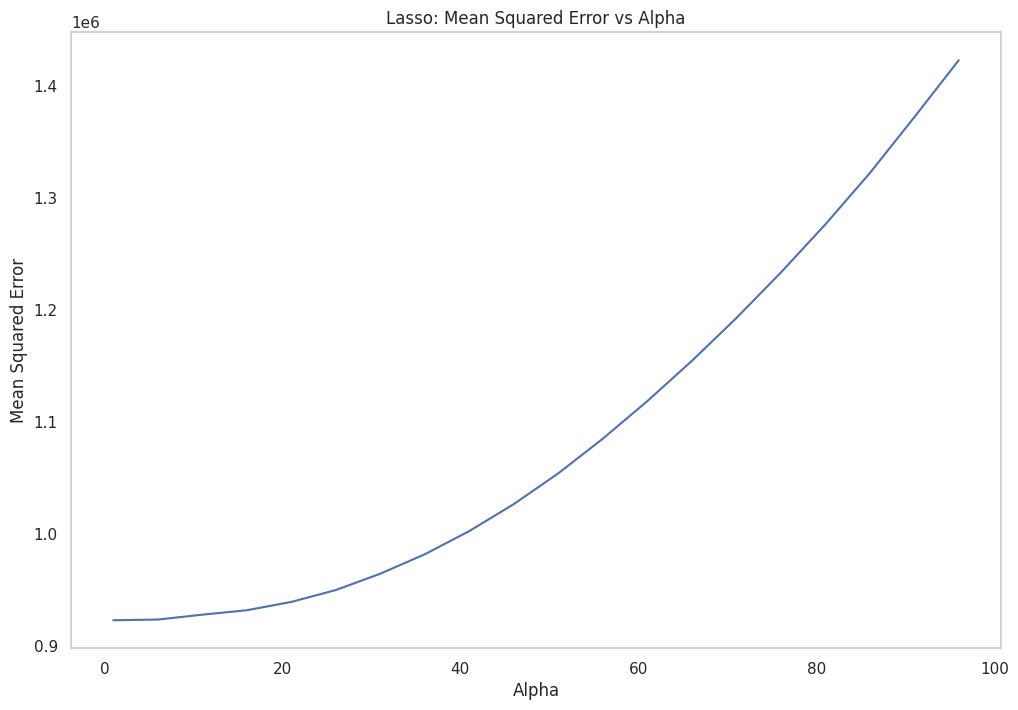

Выбранное alpha: 1
Пары 'признак-коэффициент':
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


In [26]:
from sklearn.linear_model import LassoCV

def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = [e[0] for e in data]
    y = [e[1] for e in data]
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()


alphas = np.arange(1, 100, 5)

lasso_cv = LassoCV(alphas=alphas, cv=3)
lasso_cv.fit(X, y)


data = list(zip(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1)))


title = 'Lasso: Mean Squared Error vs Alpha'
xlabel = 'Alpha'
ylabel = 'Mean Squared Error'
figsize = (12, 8)
create_plot(data, title, xlabel, ylabel, figsize)


print("Выбранное alpha:", lasso_cv.alpha_)

print("Пары 'признак-коэффициент':")
for feature, coef in zip(X.columns, lasso_cv.coef_):
    print(f"{feature}: {coef}")

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Alphas with minimum MSE:
Alpha = 1, MSE = 783221.2007323484
Alpha = 51, MSE = 606705.6506735483
Alpha = 1, MSE = 1234577.1775608219


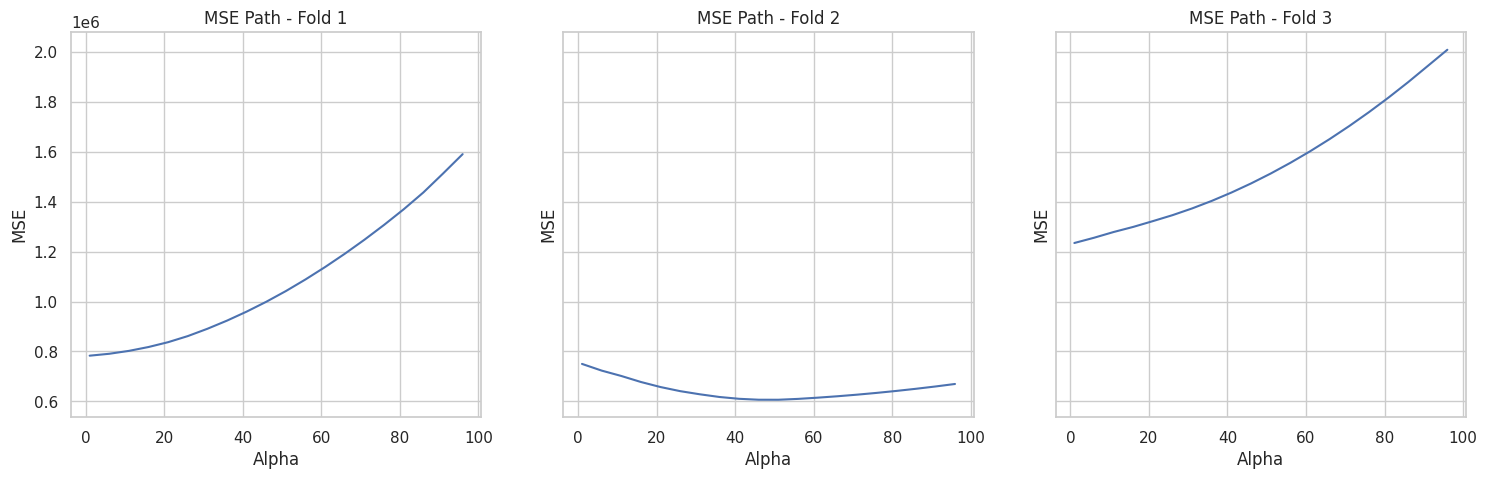

In [27]:
min_alpha_indices = np.argmin(lasso_cv.mse_path_, axis=0)
alphas_with_min_mse = lasso_cv.alphas_[min_alpha_indices]

print("Alphas with minimum MSE:")
for alpha, mse in zip(alphas_with_min_mse, np.min(lasso_cv.mse_path_, axis=0)):
    print(f"Alpha = {alpha}, MSE = {mse}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, ax in enumerate(axes):
    ax.plot(lasso_cv.alphas_, lasso_cv.mse_path_[:, i])
    ax.set_title(f'MSE Path - Fold {i+1}')
    ax.set_xlabel('Alpha')
    ax.set_ylabel('MSE')

plt.show()

In [ ]:
# Put your code here

Alphas with minimum MSE:
Alpha = 41, MSE = 843336.181499
Alpha = 6, MSE = 772598.495628
Alpha = 1, MSE = 745668.605961


На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

In [37]:
print("Все коэффициенты:")
for feature, coef in zip(X.columns, lasso_cv.coef_):
    print(f"{feature}: {coef}")

Все коэффициенты:
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?

In [32]:
top_positive_indices = np.argsort(lasso_cv.coef_)[-4:]

top_positive_features = X.columns[top_positive_indices]
top_positive_coefficients = lasso_cv.coef_[top_positive_indices]

print("4 признака с наибольшими положительными коэффициентами:")
for feature, coef in zip(top_positive_features, top_positive_coefficients):
    print(f"{feature}: {coef}")

4 признака с наибольшими положительными коэффициентами:
atemp: 69.91273749012187
workingday: 118.4475975866837
season: 506.5512786498074
yr: 2036.2316676979037


Ответ: Да , видна зависимость. И чем больше значение, тем больше людей захотят взять велосипеды.

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

In [39]:
top_negative_features_indices = np.argsort(lasso_cv.coef_)[:3]
top_negative_coefficients = lasso_cv.coef_[top_negative_features_indices]
top_negative_features_names = X.columns[top_negative_features_indices]
print("3 признака с наибольшими по модулю отрицательными коэффициентами:")
for feature, coef in zip(top_negative_features_names, top_negative_coefficients):
    print(f"{feature}: {coef}")

3 признака с наибольшими по модулю отрицательными коэффициентами:
weathersit: -604.5667118927049
holiday: -484.65194618654056
windspeed(mph): -38.34106761310847


Ответ: Можно утверждать для этих признаков : увеличение значений приведет к уменьшению спроса на велосипеды.

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

In [41]:
near_zero_features = [feature for feature, coef in zip(X.columns, lasso_cv.coef_) if abs(coef) < 1e-3]
print("Признаки с коэффициентами близкими к нулю:", near_zero_features)

Признаки с коэффициентами близкими к нулю: ['windspeed(ms)']


Ответ: "windspeed(ms)" коллинеарен "windspeed(mph)" , поэтому модель исключила его, и этот признак(при наличии "windspeed(mph)") никак уже не влияет

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации.

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.